In [ ]:
from Bio import SeqIO
import pandas as pd
import os

# مسیر فایل‌های RNALocate
rnalocate_files = {
    "Cytoplasm": "F:/New Version/Data/rnalocate/Cytoplasm_train.fasta",
    "Nucleus": "F:/New Version/Data/rnalocate/Nucleus_train.fasta",
    "Mitochondria": "F:/New Version/Data/rnalocate/Mitochondria_train.fasta",
    "Endoplasmic_reticulum": "F:/New Version/Data/rnalocate/Endoplasmic_reticulum_train.fasta",
    "Extracellular_region": "F:/New Version/Data/rnalocate/Extracellular_region_train.fasta"
}

# خواندن داده‌های RNALocate
rnalocate_data = []
label_map = {loc: i for i, loc in enumerate(rnalocate_files.keys())}

for loc, file_path in rnalocate_files.items():
    print(f"Reading {loc} from {file_path}")
    for record in SeqIO.parse(file_path, "fasta"):
        rnalocate_data.append({
            "id": record.id,
            "sequence": str(record.seq),
            "label": label_map[loc],
            "location": loc
        })

df_rnalocate = pd.DataFrame(rnalocate_data)
print(f"\n✅ RNALocate data loaded: {df_rnalocate.shape[0]} sequences.")
print(df_rnalocate['location'].value_counts())

# ذخیره فایل CSV
df_rnalocate.to_csv("F:\\payan-nameh\\faz2 . 1404.04.02\\rnalocate_dataset.csv", index=False)
print("\n📝 Saved: rnalocate_dataset.csv")

# مسیر فایل‌های CeFra-Seq
cefra_seq_path = "F:/New Version/Data/cefra-seq/cefra_seq_cDNA_screened.fa"
cefra_ann_path = "F:/New Version/Data/cefra-seq/cefra_seq_cDNA_ann_screened.fa"

# خواندن فایل توالی CeFra-Seq
cefra_seqs = []
for record in SeqIO.parse(cefra_seq_path, "fasta"):
    cefra_seqs.append({
        "id": record.id,
        "sequence": str(record.seq)
    })

df_cefra = pd.DataFrame(cefra_seqs)
print(f"\n✅ CeFra-Seq data loaded: {df_cefra.shape[0]} sequences.")

# ذخیره فایل CSV
df_cefra.to_csv("F:\\payan-nameh\\faz2 . 1404.04.02\\cefra_dataset.csv", index=False)
print("\n📝 Saved: cefra_dataset.csv")

print("\n🚀 Done! You can now use these CSVs in your model.")


In [6]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("F:\\payan-nameh\\faz2 . 1404.04.02\\rnalocate_dataset.csv")  # شامل ستون ‘sequence’ و ‘label’

# مرحله اول: Train و temp (که بعداً به val و test تقسیم میشه)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# مرحله دوم: temp → val و test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# ذخیره فایل‌ها
train_df.to_csv("F:\\payan-nameh\\faz2 . 1404.04.02\\rnalocate_train.csv", index=False)
val_df.to_csv("F:\\payan-nameh\\faz2 . 1404.04.02\\rnalocate_val.csv", index=False)
test_df.to_csv("F:\\payan-nameh\\faz2 . 1404.04.02\\rnalocate_test.csv", index=False)


In [12]:
import pandas as pd

annotation_path = "F:\\New Version\\Data\\Supplemental_File_3.tsv"
sequence_path = "F:\\payan-nameh\\faz2 . 1404.04.02\\cefra_dataset.csv"

# مشخص کردن sep برای فایل TSV
df_ann = pd.read_csv(annotation_path, sep='\t')
df_seq = pd.read_csv(sequence_path)

threshold = 10

def extract_labels(row):
    labels = []
    if row['cyto_A'] > threshold or row['cyto_B'] > threshold:
        labels.append("cytoplasm")
    if row['insol_A'] > threshold or row['insol_B'] > threshold:
        labels.append("insoluble")
    if row['membr_A'] > threshold or row['membr_B'] > threshold:
        labels.append("membrane")
    if row['nucl_A'] > threshold or row['nucl_B'] > threshold:
        labels.append("nucleus")
    return ",".join(labels)

df_ann["labels"] = df_ann.apply(extract_labels, axis=1)

merged_df = pd.merge(
    df_seq.rename(columns={"id": "ensembl_gene_id"}),
    df_ann[["ensembl_gene_id", "labels"]],
    on="ensembl_gene_id"
)

merged_df = merged_df[merged_df["labels"] != ""]

merged_df.to_csv("F:\\payan-nameh\\faz2 . 1404.04.02\\cefra_labeled_data.tsv", sep='\t', index=False)


تعداد نمونه‌های چندبرچسبی: 4200
از کل 5668 نمونه، حدوداً 74.10% چندبرچسبی هستند.


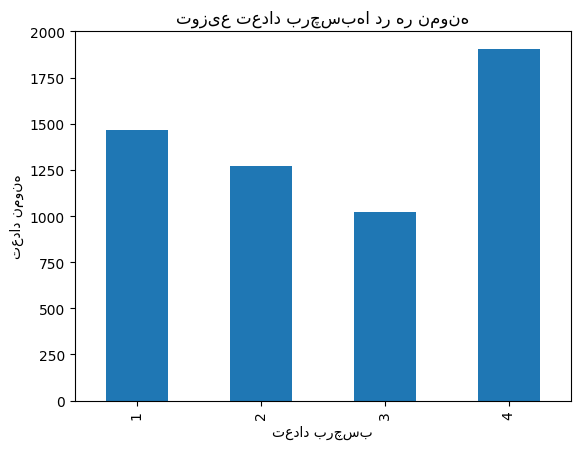

In [13]:
import pandas as pd

# بارگذاری داده
df = pd.read_csv("F:\\payan-nameh\\faz2 . 1404.04.02\\cefra_labeled_data.tsv", sep="\t")

# تعداد برچسب‌ها برای هر نمونه
df["label_count"] = df["labels"].apply(lambda x: len(x.split(",")))

# بررسی چندبرچسبی بودن
multi_label_samples = df[df["label_count"] > 1]
print(f"تعداد نمونه‌های چندبرچسبی: {len(multi_label_samples)}")
print(f"از کل {len(df)} نمونه، حدوداً {len(multi_label_samples)/len(df)*100:.2f}% چندبرچسبی هستند.")

# نمایش تعداد برچسب‌ها در هر نمونه به صورت هیستوگرام (اختیاری اگر matplotlib نصب هست)
try:
    import matplotlib.pyplot as plt
    df["label_count"].value_counts().sort_index().plot(kind="bar")
    plt.title("توزیع تعداد برچسب‌ها در هر نمونه")
    plt.xlabel("تعداد برچسب")
    plt.ylabel("تعداد نمونه")
    plt.show()
except ImportError:
    pass


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# بارگذاری داده برچسب‌خورده
df = pd.read_csv("F:\\payan-nameh\\faz2 . 1404.04.02\\cefra_labeled_data.tsv", sep="\t")

# برداشتن sequence و labels
X = df["sequence"].values
y = df["labels"].apply(lambda x: x.split(","))

# ساخت DataFrame از برچسب‌ها به صورت باینری برای stratified split
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)

# تقسیم اولیه: Train و موقت باقی‌مانده (Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_bin, test_size=0.30, random_state=42, stratify=y_bin)

# تقسیم دوم: Validation و Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# ذخیره داده‌ها در فرمت CSV
def save_csv(X_split, y_split, filename):
    label_str = mlb.inverse_transform(y_split)
    df_out = pd.DataFrame({
        "sequence": X_split,
        "labels": [",".join(lbls) for lbls in label_str]
    })
    df_out.to_csv(filename, index=False)  # sep حذف شده چون پیش‌فرض "," هست

save_csv(X_train, y_train, "F:\\payan-nameh\\faz2 . 1404.04.02\\cefra_train.csv")
save_csv(X_val, y_val, "F:\\payan-nameh\\faz2 . 1404.04.02\\cefra_val.csv")
save_csv(X_test, y_test, "F:\\payan-nameh\\faz2 . 1404.04.02\\cefra_test.csv")

print("✅ داده‌ها با موفقیت تقسیم و در فرمت CSV ذخیره شدند:")
print(f"تعداد Train: {len(X_train)}")
print(f"تعداد Validation: {len(X_val)}")
print(f"تعداد Test: {len(X_test)}")


✅ داده‌ها با موفقیت تقسیم و در فرمت CSV ذخیره شدند:
تعداد Train: 3967
تعداد Validation: 850
تعداد Test: 851
